In [1]:
import pandas as pd
import altair as alt

### 0) Pull Podcast data from iTunes with Applescript/Coffeescript  
In some cases podcasts don't have the 'media type' of "Podcast," but we'll ignore those for now.

```coffeescript
tell application "iTunes"
	set trackData to "name|duration|album|artist|composer|genre|playedCount|datePlayed|dateAdded|unplayed|year|description\n"
	repeat with aTrack in tracks of library playlist 1
		set td to ""
		set td to td & name of aTrack & "|"
		set td to td & duration of aTrack & "|"
		set td to td & album of aTrack & "|"
		set td to td & artist of aTrack & "|"
		set td to td & composer of aTrack & "|"
		set td to td & genre of aTrack & "|"
		set td to td & played count of aTrack & "|"
		set td to td & played date of aTrack & "|"
		set td to td & date added of aTrack & "|"
		set td to td & unplayed of aTrack & "|"
		set td to td & year of aTrack & "|"
		set td to td & long description of aTrack & "\n"
		
		set trackData to trackData & td
	end repeat
	copy trackData to stdout
end tell
```  
  
This is run from bash with:
```bash
    osascript pullTrackData_upd101517.scpt > podcastdatapull_upd102117.txt
```

### 1) set up the result

In [2]:
raw_data = pd.read_table('data/datapull_upd102617.txt',
                         sep='|',error_bad_lines=False, warn_bad_lines=False,
                         dtype={'year':str}
                        )
print(raw_data.shape)
raw_data.head()

(10475, 13)


,name,mediaKind,duration,album,artist,composer,genre,playedCount,datePlayed,dateAdded,unplayed,year,description
0,Riots,«constant ****kMdS»,119.50700378418,Slumdog Millionaire (Music from the Motion Pic...,A. R. Rahman,A. R. Rahman,Soundtrack,0.0,missing value,"Saturday, March 7, 2009 at 20:27:41",True,2008,missing value
1,Mausam & Escape,«constant ****kMdS»,232.839996337891,Slumdog Millionaire (Music from the Motion Pic...,A. R. Rahman,A. R. Rahman,Soundtrack,0.0,missing value,"Saturday, March 7, 2009 at 20:27:41",True,2008,missing value
2,O... Saya,«constant ****kMdS»,213.826995849609,Slumdog Millionaire (Music from the Motion Pic...,A. R. Rahman & M.I.A.,A. R. Rahman,Soundtrack,0.0,missing value,"Saturday, March 7, 2009 at 20:27:41",True,2008,missing value
3,Millionaire,«constant ****kMdS»,164.427001953125,Slumdog Millionaire (Music from the Motion Pic...,A. R. Rahman & Madhumitha,A. R. Rahman,Soundtrack,0.0,missing value,"Saturday, March 7, 2009 at 20:27:41",True,2008,missing value
4,Latika's Theme,«constant ****kMdS»,189.373001098633,Slumdog Millionaire (Music from the Motion Pic...,A. R. Rahman & Suzanne,A. R. Rahman,Soundtrack,0.0,missing value,"Saturday, March 7, 2009 at 20:27:41",True,2008,missing value


### 2) Preliminary processing
- remove things with no descriprtion
- that have no played date
- that also weren't flagged as unplayed
- that also have a time duration

In [3]:
podcast_data = raw_data[(raw_data['description'] != 'missing value') 
                        & (raw_data['duration'] != 'missing value') 
                        & (raw_data['unplayed']==False)
                        & (raw_data['datePlayed']!='missing value')].copy()
podcast_data.drop(['mediaKind','composer'],axis=1,inplace=True)
podcast_data.loc[:,'datePlayed'] = pd.core.tools.datetimes.to_datetime(podcast_data['datePlayed'])
podcast_data.loc[:,'dateAdded'] = pd.core.tools.datetimes.to_datetime(podcast_data['dateAdded'])
podcast_data.loc[:,'description'] = podcast_data['description'].str.lower()
print(podcast_data.shape)
podcast_data.head()

(6153, 11)


,name,duration,album,artist,genre,playedCount,datePlayed,dateAdded,unplayed,year,description
10,A.D.K.O.B. - Helium,253.0,KEXP Song of the Day,A.D.K.O.B.,Podcast,1.0,2017-09-28 09:29:47,2017-09-28 06:43:37,False,2017,a.d.k.o.b. - helium - a 2017 single on wonderl...
11,A.D.K.O.B. - Lung Capacity,172.0,KEXP Song of the Day,A.D.K.O.B.,Podcast,1.0,2017-08-13 22:47:02,2017-01-30 06:15:32,False,0,a.d.k.o.b. - lung capacity - from the 2015 a d...
12,Aan - All You Have to Say,214.0,KEXP Song of the Day,Aan,Podcast,1.0,2017-01-20 11:03:50,2017-01-21 11:16:12,False,2016,aan - all you have to say - from the 2016 albu...
16,Ablebody - Backseat Heart,297.0,KEXP Song of the Day,Ablebody,Podcast,1.0,2017-01-03 13:11:12,2017-01-30 06:15:32,False,0,ablebody - backseat heart - from the 2016 albu...
33,Acapulco Lips,1269.0,KEXP Live Performances Podcast,Acapulco Lips,Podcast,1.0,2017-01-01 08:03:15,2017-01-30 06:14:26,False,0,"maria-elena juarez, christopher garland, and d..."


### 3) Initial generated fields
These will help with categorizations in data exploration

In [4]:
# 3.1) What was the listen day?
podcast_data['dateAdded_DoW'] = podcast_data['dateAdded'].dt.strftime('%a')
podcast_data['datePlayed_DoW'] = podcast_data['datePlayed'].dt.strftime('%a')

In [5]:
# 3.2) What part of the day was it consumed?
def bin_f(x):
    h = pd.datetime.time(x).hour
    if h < 6:
        return "em" #early morning
    elif h < 12:
        return "m" # morning
    elif h < 18:
        return "a" # afternoon
    else:
        return "e" # evening
    
podcast_data['dateAdded_Part'] = podcast_data['dateAdded'].apply(lambda i: bin_f(i))
podcast_data['datePlayed_Part'] = podcast_data['datePlayed'].apply(lambda i: bin_f(i))

In [6]:
# 3.3 How many seconds were there since adding the podcast?
# negative values indicate an error in syncing, or a new podcast subsciption
podcast_data['downloadToPlay_Seconds'] = (podcast_data['datePlayed'] - podcast_data['dateAdded']).dt.total_seconds()

# add error indicator, this is a catch-all
podcast_data['syncSubError_Ind'] = podcast_data['downloadToPlay_Seconds'] < 0

In [7]:
# 3.4 Was it played in the same day?
podcast_data['playedSameDay_Ind'] = ((podcast_data['dateAdded_DoW'] == podcast_data['datePlayed_DoW'])\
                                    & (podcast_data['downloadToPlay_Seconds'] < 86400)\
                                    & (podcast_data['downloadToPlay_Seconds'] >= 0)
                                    )
podcast_data.head()

,name,duration,album,artist,genre,playedCount,datePlayed,dateAdded,unplayed,year,description,dateAdded_DoW,datePlayed_DoW,dateAdded_Part,datePlayed_Part,downloadToPlay_Seconds,syncSubError_Ind,playedSameDay_Ind
10,A.D.K.O.B. - Helium,253.0,KEXP Song of the Day,A.D.K.O.B.,Podcast,1.0,2017-09-28 09:29:47,2017-09-28 06:43:37,False,2017,a.d.k.o.b. - helium - a 2017 single on wonderl...,Thu,Thu,m,m,9970.0,False,True
11,A.D.K.O.B. - Lung Capacity,172.0,KEXP Song of the Day,A.D.K.O.B.,Podcast,1.0,2017-08-13 22:47:02,2017-01-30 06:15:32,False,0,a.d.k.o.b. - lung capacity - from the 2015 a d...,Mon,Sun,m,e,16907490.0,False,False
12,Aan - All You Have to Say,214.0,KEXP Song of the Day,Aan,Podcast,1.0,2017-01-20 11:03:50,2017-01-21 11:16:12,False,2016,aan - all you have to say - from the 2016 albu...,Sat,Fri,m,m,-87142.0,True,False
16,Ablebody - Backseat Heart,297.0,KEXP Song of the Day,Ablebody,Podcast,1.0,2017-01-03 13:11:12,2017-01-30 06:15:32,False,0,ablebody - backseat heart - from the 2016 albu...,Mon,Tue,m,a,-2307860.0,True,False
33,Acapulco Lips,1269.0,KEXP Live Performances Podcast,Acapulco Lips,Podcast,1.0,2017-01-01 08:03:15,2017-01-30 06:14:26,False,0,"maria-elena juarez, christopher garland, and d...",Mon,Sun,m,m,-2499071.0,True,False


### 4) Generate summary based on the current data (and wander around some data cleaning issues)
Let's start with a basic question - <b><i>when are most podcasts played?<i><b>

In [8]:
# summarize data overall by played day of week and see if there are any patterns
played_summary = podcast_data[['datePlayed_DoW','name']].groupby(['datePlayed_DoW']).count().reset_index()
played_summary.rename(columns={'name':'count'},inplace=True)
alt.Chart(played_summary
         ).mark_bar().encode(
    y='datePlayed_DoW',
    x='count'
)

/Users/BEugeneSmith/anaconda3/lib/python3.5/site-packages/altair/utils/core.py:110: FutureWarning: pandas.lib is deprecated and will be removed in a future version.
You can access infer_dtype as pandas.api.types.infer_dtype
  typ = pd.lib.infer_dtype(data)


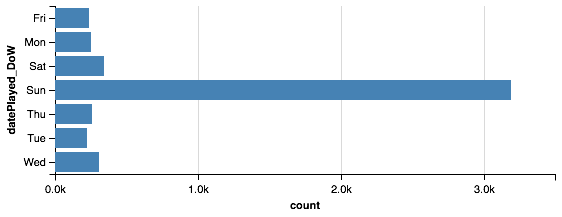

In [9]:
# What happens when we remove the instances with sync or subscription errors flagged?
podcast_data_noSSError = podcast_data[podcast_data['syncSubError_Ind']==False]
played_summary_noSSError = podcast_data_noSSError[['datePlayed_DoW','name']].groupby(['datePlayed_DoW']).count().reset_index()
played_summary_noSSError.rename(columns={'name':'count'},inplace=True)
alt.Chart(played_summary_noSSError
         ).mark_bar().encode(
    y='datePlayed_DoW',
    x='count'
)

It looks like there's still a spike on Sunday, so why is that? I expect the following explainations to apply:  
- It doesn't interest me and I for some reason feel that I'll have time to passively consume it   
- I've put off listening to it for a while (at least a week)  
- I've just added the podcast, and don't want to go through the backlog/see it in my feed  
  
That leads to the following question - <b><i>what is the breakdown of the volume that was played on Sunday?<b><i>

In [10]:
# summarize data with no time error by day played, added, and podcast name
played_summary_by_podcast = podcast_data_noSSError[['datePlayed_DoW','dateAdded_DoW','name','dateAdded_Part','datePlayed_Part','album']]\
    .groupby(['datePlayed_DoW','dateAdded_DoW','dateAdded_Part','datePlayed_Part','album']).count().reset_index()
played_summary_by_podcast.rename(columns={'name':'count'},inplace=True)

# Isolate just the Sunday data
sundayPodcastData = played_summary_by_podcast[played_summary_by_podcast['datePlayed_DoW']=='Sun']
sundayPodcastData_agg = sundayPodcastData[['album','count']].groupby('album').sum().reset_index()
sundayPodcastData_agg.sort_values('count',ascending=False).head(10)

,album,count
21,KEXP Song of the Day,373
43,Savage Lovecast,259
40,RISK!,253
39,Pop Culture Happy Hour,247
1,99% Invisible,241
3,All Songs Considered,231
20,KEXP Presents Music That Matters,209
34,Planet Money,206
49,Spilled Milk,190
11,Freakonomics Radio,180


Looking at the top ten podcasts played on Sunday, I would guess that I either delay playing these, or when I set up iTunes on this machine, I marked lots of episodes of this podcast as played. For some like Savage Lovecast and RISK!, that I'm less likely to listen to right away, I backlog those through the week and listen to them while doing things around the house. To capture this, I'll only consider podcasts that were listened to after the date I added KEXP Song of the Day podcast.

In [11]:
# get counts of each date type and isolate the ones that have a repeated play date
datePlayedCounts = podcast_data[['datePlayed','name']].groupby('datePlayed').count().reset_index()
datePlayedCounts_dedup = datePlayedCounts[datePlayedCounts['name']>1]['datePlayed']

# Create indicator to isolate records that are duplicates for play date and omit them
podcast_data['dupDate_Ind'] = (podcast_data['datePlayed'].isin(datePlayedCounts_dedup))
podcast_data = podcast_data[podcast_data['dupDate_Ind']==True]

print(podcast_data.shape)
podcast_data.head()

(3550, 19)


,name,duration,album,artist,genre,playedCount,datePlayed,dateAdded,unplayed,year,description,dateAdded_DoW,datePlayed_DoW,dateAdded_Part,datePlayed_Part,downloadToPlay_Seconds,syncSubError_Ind,playedSameDay_Ind,dupDate_Ind
11,A.D.K.O.B. - Lung Capacity,172.0,KEXP Song of the Day,A.D.K.O.B.,Podcast,1.0,2017-08-13 22:47:02,2017-01-30 06:15:32,False,0,a.d.k.o.b. - lung capacity - from the 2015 a d...,Mon,Sun,m,e,16907490.0,False,False,True
33,Acapulco Lips,1269.0,KEXP Live Performances Podcast,Acapulco Lips,Podcast,1.0,2017-01-01 08:03:15,2017-01-30 06:14:26,False,0,"maria-elena juarez, christopher garland, and d...",Mon,Sun,m,m,-2499071.0,True,False,True
34,Acapulco Lips - Awkward Waltz,229.0,KEXP Song of the Day,Acapulco Lips,Podcast,1.0,2017-08-13 22:47:02,2017-01-30 06:15:32,False,0,acapulco lips - awkward waltz - from the 2016 ...,Mon,Sun,m,e,16907490.0,False,False,True
36,Ep 31: Courtney Jung on the History of Formula...,3553.0,Adam Ruins Everything,Adam Conover & Courtney Jung,Podcast,2.0,2017-07-22 09:00:08,2017-07-21 00:15:26,False,2017,<div>one of the most controversial topics is w...,Fri,Sat,em,m,117882.0,False,False,True
43,Addaura,1222.0,KEXP Live Performances Podcast,Addaura,Podcast,1.0,2017-01-01 08:03:15,2017-01-30 06:14:26,False,0,"seattle-based crushing, atmospheric black-meta...",Mon,Sun,m,m,-2499071.0,True,False,True


This dataset gives a reasonable amount of data to work with, without the potential error of episodes that were marked as played in batch. If we were to reprocess this as above, we'd see that volumes for many of these is slightly lower, with the majority of volume still being on Sunday. 

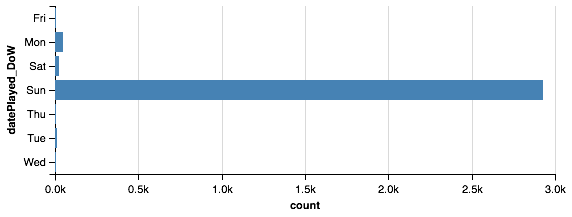

In [12]:
# What happens when we remove the instances with sync or subscription errors flagged?
podcast_data_noSSError = podcast_data[podcast_data['syncSubError_Ind']==False]
played_summary_noSSError = podcast_data_noSSError[['datePlayed_DoW','name']].groupby(['datePlayed_DoW']).count().reset_index()
played_summary_noSSError.rename(columns={'name':'count'},inplace=True)
alt.Chart(played_summary_noSSError
         ).mark_bar().encode(
    y='datePlayed_DoW',
    x='count'
)

In [13]:
# summarize data with no time error by day played, added, and podcast name
played_summary_by_podcast = podcast_data_noSSError[['datePlayed_DoW','dateAdded_DoW','name','dateAdded_Part','datePlayed_Part','album']]\
    .groupby(['datePlayed_DoW','dateAdded_DoW','dateAdded_Part','datePlayed_Part','album']).count().reset_index()
played_summary_by_podcast.rename(columns={'name':'count'},inplace=True)

# Isolate just the Sunday data
noDupDate_sundayPodcastData = played_summary_by_podcast[played_summary_by_podcast['datePlayed_DoW']=='Sun']
noDupDate_sundayPodcastData_agg = noDupDate_sundayPodcastData[['album','count']].groupby('album').sum().reset_index()
noDupDate_sundayPodcastData_agg.sort_values('count',ascending=False).head(10)

,album,count
12,KEXP Song of the Day,373
26,Savage Lovecast,255
23,RISK!,248
22,Pop Culture Happy Hour,241
1,99% Invisible,239
2,All Songs Considered,223
11,KEXP Presents Music That Matters,200
18,Planet Money,199
29,Spilled Milk,184
6,Freakonomics Radio,176


In [14]:
dupAggComp = sundayPodcastData_agg.merge(noDupDate_sundayPodcastData_agg,on='album',how='left')
dupAggComp.rename(columns={'count_x':'count_before','count_y':'count_after'},inplace=True)
dupAggComp.fillna(0,inplace=True)
dupAggComp['countDiff'] = dupAggComp['count_after'] - dupAggComp['count_before']

# Look at whihc ones were dropped altogether
dupAggComp[(dupAggComp['countDiff']<0)\
          & (dupAggComp['count_after']==0)].sort_values('countDiff')

,album,count_before,count_after,countDiff
27,Monocle 24: The Monocle Weekly,12,0.0,-12.0
26,Monocle 24: The Monocle Daily,6,0.0,-6.0
5,Call Your Girlfriend,5,0.0,-5.0
47,Song Exploder,5,0.0,-5.0
44,Science Vs,5,0.0,-5.0
48,Song of the Day,4,0.0,-4.0
58,With Friends Like These,4,0.0,-4.0
9,Fake The Nation,4,0.0,-4.0
6,Clever,3,0.0,-3.0
23,Lovett or Leave It,3,0.0,-3.0


In [15]:
# volume of everything that can still be analyzed
dupAggComp[(dupAggComp['count_after']>0)].sort_values('countDiff')

,album,count_before,count_after,countDiff
14,Global News Podcast,31,3.0,-28.0
32,On the Media,15,3.0,-12.0
56,Wait Wait... Don't Tell Me!,11,1.0,-10.0
55,Tiny Desk Concerts - Audio,11,2.0,-9.0
30,No Such Thing As A Fish,10,1.0,-9.0
20,KEXP Presents Music That Matters,209,200.0,-9.0
25,Monocle 24: Section D,10,2.0,-8.0
3,All Songs Considered,231,223.0,-8.0
19,KEXP Live Performances Podcast,10,2.0,-8.0
28,Monocle 24: The Urbanist,8,1.0,-7.0


The change differed by 5 on average, but this process did drop may of the podcasts I value, and consider important to my media diet, so for now they will be omitted and I'll work with those that are more likely (knowing my podcast consumption habits) to be an accurate measure of download to play date.  
  
Based on the podcasts that have been eliminated by removing the duplicates, I can already tell that this analysis will be biased towards:  
1) Podcasts that I have been listening to for a shorter period of time  
2) Podcasts that have lower frequency of release  
  
Here are some quick summary stats:

In [16]:
dupAggComp.describe()

,count_before,count_after,countDiff
count,59.000000,59.00000,59.000000
mean,54.084746,49.59322,-4.491525
std,91.495108,91.50544,4.276531
min,1.000000,0.00000,-28.000000
25%,3.000000,0.00000,-6.000000
50%,8.000000,1.00000,-3.000000
75%,37.500000,31.00000,-2.000000
max,373.000000,373.00000,0.000000


In [17]:
# a quick remidner of what our data looks like
podcast_data.head()

,name,duration,album,artist,genre,playedCount,datePlayed,dateAdded,unplayed,year,description,dateAdded_DoW,datePlayed_DoW,dateAdded_Part,datePlayed_Part,downloadToPlay_Seconds,syncSubError_Ind,playedSameDay_Ind,dupDate_Ind
11,A.D.K.O.B. - Lung Capacity,172.0,KEXP Song of the Day,A.D.K.O.B.,Podcast,1.0,2017-08-13 22:47:02,2017-01-30 06:15:32,False,0,a.d.k.o.b. - lung capacity - from the 2015 a d...,Mon,Sun,m,e,16907490.0,False,False,True
33,Acapulco Lips,1269.0,KEXP Live Performances Podcast,Acapulco Lips,Podcast,1.0,2017-01-01 08:03:15,2017-01-30 06:14:26,False,0,"maria-elena juarez, christopher garland, and d...",Mon,Sun,m,m,-2499071.0,True,False,True
34,Acapulco Lips - Awkward Waltz,229.0,KEXP Song of the Day,Acapulco Lips,Podcast,1.0,2017-08-13 22:47:02,2017-01-30 06:15:32,False,0,acapulco lips - awkward waltz - from the 2016 ...,Mon,Sun,m,e,16907490.0,False,False,True
36,Ep 31: Courtney Jung on the History of Formula...,3553.0,Adam Ruins Everything,Adam Conover & Courtney Jung,Podcast,2.0,2017-07-22 09:00:08,2017-07-21 00:15:26,False,2017,<div>one of the most controversial topics is w...,Fri,Sat,em,m,117882.0,False,False,True
43,Addaura,1222.0,KEXP Live Performances Podcast,Addaura,Podcast,1.0,2017-01-01 08:03:15,2017-01-30 06:14:26,False,0,"seattle-based crushing, atmospheric black-meta...",Mon,Sun,m,m,-2499071.0,True,False,True


### 5) Clean the remaing text  (insert terrified manic laughter) and transform into a TP matrix
(And thank the Data Science gods for [Chris Albon](https://chrisalbon.com/python/cleaning_text.html))

In [18]:
import string
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [19]:
descriptions = podcast_data['description'].astype(str).apply(word_tokenize)

regex = re.compile('[%s]' % re.escape(string.punctuation)) 

descriptions_no_punctuation = []

for review in descriptions:

    new_review = []
    for token in review: 
        new_token = regex.sub(u'', token)
        if not new_token == u'':
            new_review.append(new_token)

    descriptions_no_punctuation.append(new_review)

In [20]:
tokenized_descriptions_no_stopwords = []
for report in descriptions_no_punctuation:
    new_term_vector = []
    for word in report:
        if not word in stopwords.words('english'):
            new_term_vector.append(word)
    tokenized_descriptions_no_stopwords.append(new_term_vector)

In [21]:
testdata = tokenized_descriptions_no_stopwords

PresHash = {}
allTerms = [item for sublist in testdata for item in sublist]
uniqueTerms = []
for term in allTerms:
    if term not in uniqueTerms:
        PresHash[term] = [0 for i in range(len(testdata))]
        uniqueTerms.append(term)
        
for ix,wordVec in enumerate(testdata): # make sure to yodatethe test data
    for word in PresHash.keys():
        if word in list(set(wordVec)):
            PresHash[word][ix] = 1
            
term_presence_matrix = pd.DataFrame(PresHash)

In [22]:
term_presence_matrix

,0,000000,0001pt,0033cc,01062015,01092015,01102014,01122016,01132015,01152014,...,—them,‘,’,“,”,…,…friend,→,∆,★
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
